# air quality

In [ ]:
import pandas as pd
# pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import math
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy import stats
import statistics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from operator import itemgetter
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot
import statsmodels.api as sm

In [2]:
TRAIN = pd.read_csv('TRAINING_DATA.txt')

TEST = pd.read_csv('TESTING_DATA.txt')

# feature engineering
holidays:
- http://www.unitarium.com/blog/articles/list-of-federal-holidays-2010
- https://www.timeanddate.com/date/durationresult.html?m1=1&d1=31&y1=2010&m2=09&d2=06&y2=2010
congestion data:
- https://www.wbez.org/shows/curious-city/when-is-chicagoarea-traffic-the-worst/73cf66f9-8a44-4227-8619-68220de78ad3

## simple features

In [3]:
# TRAIN

# temp diff between altitudes
TRAIN['temp_diff'] = TRAIN['temperature.1']-TRAIN['temperature.30']
TRAIN['temp_diff_abs'] = np.abs(TRAIN['temperature.1']-TRAIN['temperature.30'])

# check if weekday, counting monday as day 0, sunday as 6, [15,120,157,218]
TRAIN['weekday'] = (((TRAIN['day.index']-1)%7 < 5) | (TRAIN['day.index'] == 15) | (TRAIN['day.index'] == 120) | (TRAIN['day.index'] == 157)  )*1

#cos/sin
TRAIN['cos'] = np.cos((TRAIN['wind.direction']+90)*(180/math.pi))
TRAIN['sin'] = np.sin((TRAIN['wind.direction']+90)*(180/math.pi))
TRAIN['cos_abs'] = np.abs(TRAIN['cos'])
TRAIN['sin_abs'] = np.abs(TRAIN['sin'])



# TEST

# temp diff between altitudes
TEST['temp_diff'] = TEST['temperature.1']-TEST['temperature.30']
TEST['temp_diff_abs'] = np.abs(TEST['temperature.1']-TEST['temperature.30'])

# check if weekday, counting monday as day 0, sunday as 6, [15,120,157,218]
TEST['weekday'] = (((TEST['day.index']-1)%7 < 5) | (TEST['day.index'] == 15) | (TEST['day.index'] == 120) | (TEST['day.index'] == 157)  )*1

#cos/sin
TEST['cos'] = np.cos((TEST['wind.direction']+75)*(180/math.pi))
TEST['sin'] = np.sin((TEST['wind.direction']+75)*(180/math.pi))
TEST['cos_abs'] = np.abs(TEST['cos'])
TEST['sin_abs'] = np.abs(TEST['sin'])



## complex features

### since sunrise

In [4]:
def since_sunrise(hour,dayindex):
    
    series = [7,6.5,6,7,6,5.5,5,5.5,6.5,7,6,6.5,7]
    
    month = dayindex/30 + 1
    
    sunrise = series[int(month)]*(1-(month%1)) + series[int(month)+1]*(month%1)
    
    if hour<sunrise:
        
        return hour+24 - sunrise
    
    else:
        
        return hour-sunrise
    
#add hours since sunrise by day.index and hour
TRAIN['since_sunrise'] = pd.Series(np.zeros(300))
for index in TRAIN.index:
    TRAIN['since_sunrise'][index] = since_sunrise(TRAIN['time.of.day'][index],TRAIN['day.index'][index])
    

    #add hours since sunrise by day.index and hour
TEST['since_sunrise'] = pd.Series(np.zeros(200))
for index in TEST.index:
    TEST['since_sunrise'][index] = since_sunrise(TEST['time.of.day'][index],TEST['day.index'][index])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### daily congestion

In [5]:
def daily_congestion(dayindex,hour):
    
    series = [.85,.9,1,1.1,1.05,1,1.05,1.05,1.1,1.1,1.1,1.05,1,.95,.95]
    
    day = dayindex%7
    
    week_hour = (day*24+hour)/12
    
    return series[int(round(week_hour))]/min(series)

TRAIN['daily_congestion'] = pd.Series(np.zeros(300))
for index in TRAIN.index:
    TRAIN['daily_congestion'][index] = daily_congestion(TRAIN['day.index'][index],TRAIN['time.of.day'][index])
    
TEST['daily_congestion'] = pd.Series(np.zeros(200))
for index in TEST.index:
    TEST['daily_congestion'][index] = daily_congestion(TEST['day.index'][index],TEST['time.of.day'][index])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### hourly congestion weekday

In [6]:
def hourly_congestion_weekday(hour):
    
    series = [1.5,1,1,1.5,2.5,4,6,6,6,5.5,5,5.5,5.5,6,6.5,7,7.5,6.5,5.5,5,4.5,3.5,3,2.5]
        
    return series[int(hour)-1]

TRAIN['hourly_congestion_weekday'] = pd.Series(np.zeros(300))
for index in TRAIN.index:
    TRAIN['hourly_congestion_weekday'][index] = hourly_congestion_weekday(TRAIN['time.of.day'][index])
    
TEST['hourly_congestion_weekday'] = pd.Series(np.zeros(200))
for index in TEST.index:
    TEST['hourly_congestion_weekday'][index] = hourly_congestion_weekday(TEST['time.of.day'][index])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


### hourly congestion weekend

In [7]:
def hourly_congestion_weekend(hour):
    
    series = [.85]*8+[1]*13+[.85]*3
        
    return series[int(hour)-1]/min(series)

TRAIN['hourly_congestion_weekend'] = pd.Series(np.zeros(300))
for index in TRAIN.index:
    TRAIN['hourly_congestion_weekend'][index] = hourly_congestion_weekend(TRAIN['time.of.day'][index])
    
TEST['hourly_congestion_weekend'] = pd.Series(np.zeros(200))
for index in TEST.index:
    TEST['hourly_congestion_weekend'][index] = hourly_congestion_weekend(TEST['time.of.day'][index])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


### monthly congestion

In [8]:
def monthly_congestion(dayindex):
    
    month = dayindex/30 + 1
    
    whole = int(month)
    remainder = month%1
    
    series = [.9,.95,1,1,1.03,1.05,1.1,1.05,1,1,1,1,.9]
        
    return (series[whole]*(1-remainder) + series[whole+1]*(remainder))/min(series)

TRAIN['monthly_congestion'] = pd.Series(np.zeros(300))
for index in TRAIN.index:
    TRAIN['monthly_congestion'][index] = monthly_congestion(TRAIN['day.index'][index])
    
TEST['monthly_congestion'] = pd.Series(np.zeros(200))
for index in TEST.index:
    TEST['monthly_congestion'][index] = monthly_congestion(TEST['day.index'][index])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### total congestion

In [9]:
TRAIN['total_congestion'] = TRAIN['monthly_congestion']*TRAIN['daily_congestion']*(TRAIN['hourly_congestion_weekday']*TRAIN['weekday'] + TRAIN['hourly_congestion_weekend']*(1-TRAIN['weekday']))
TEST['total_congestion'] = TEST['monthly_congestion']*TEST['daily_congestion']*(TEST['hourly_congestion_weekday']*TEST['weekday'] + TEST['hourly_congestion_weekend']*(1-TEST['weekday']))

# scale features

In [10]:
TRAIN['total_congestion.scaled'] = TRAIN['total_congestion']**.72
TRAIN['car.count.scaled'] = (TRAIN['car.count'])**.68
TRAIN['temp_diff_abs.scaled'] = TRAIN['temp_diff_abs']**.71
TRAIN['temperature.30.scaled'] = ((TRAIN['temperature.30']+273.15)/273.15)**3
TRAIN['wind.velocity.scaled'] = TRAIN['wind.velocity']**1.04
TRAIN['since_sunrise.scaled'] = TRAIN['since_sunrise']**.36
TRAIN['cos_abs.scaled'] = (TRAIN['cos_abs'])**1.59
TRAIN['sin.scaled'] = (np.abs(TRAIN['sin'])**3)*np.sign(TRAIN['sin'])
TRAIN['temp_diff.scaled'] = np.abs(TRAIN['temp_diff'])**1.17 * np.sign(TRAIN['temp_diff'])


TEST['total_congestion.scaled'] = TEST['total_congestion']**.72
TEST['car.count.scaled'] = (TEST['car.count'])**.68
TEST['temp_diff_abs.scaled'] = TEST['temp_diff_abs']**.71
TEST['temperature.30.scaled'] = ((TEST['temperature.30']+273.15)/273.15)**3
TEST['wind.velocity.scaled'] = TEST['wind.velocity']**1.04
TEST['since_sunrise.scaled'] = TEST['since_sunrise']**.36
TEST['cos_abs.scaled'] = (TEST['cos_abs'])**1.59
TEST['sin.scaled'] = (np.abs(TEST['sin'])**3)*np.sign(TEST['sin'])
TEST['temp_diff.scaled'] = np.abs(TEST['temp_diff'])**1.17 * np.sign(TEST['temp_diff'])

# remove outliers

In [11]:
TRAIN = TRAIN[TRAIN['so2']<150]

# visualize/experiment

slope, intercept, r_value, p_value, std_err =  LinregressResult(slope=-0.721829650673952, intercept=59.0585639303455, rvalue=-0.22073410783077094, pvalue=0.00013936101306096858, stderr=0.1869700960594644)


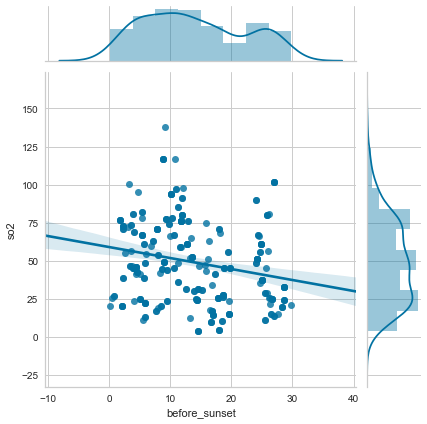

In [33]:
x = TRAIN['before_sunset']
y = TRAIN['so2']

sns.jointplot(x,y,kind='reg')

print('slope, intercept, r_value, p_value, std_err = ',stats.linregress(x,y))

In [13]:
keep = [
    'car.count.scaled',
    'wind.velocity.scaled',
    'temperature.30.scaled',
    'temp_diff_abs.scaled',
    'temp_diff.scaled',
    'total_congestion.scaled',
    'since_sunrise.scaled',
    'sin.scaled',
    'cos_abs.scaled',
]

X = TRAIN.drop(columns = ['so2'])[keep]
Y = TRAIN['so2']

len(keep)

9

In [14]:
regressor = LinearRegression()  
regressor.fit(X, Y)
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
pred_y = regressor.predict(X)
res = Y-pred_y
df = pd.DataFrame({'Actual': Y, 'Predicted': pred_y,'Res':y})


print('r2_score : '+str(r2_score(Y, pred_y)))

r2_score : 0.6222247647452952


In [15]:
values = []

keep_all = [
    'car.count',
    'wind.velocity',
    'temperature.30',
    'temp_diff',
    'temp_diff_abs',
    'total_congestion',
    'since_sunrise',
    'sin',
    'cos_abs',
]

for k in keep_all:
    
    _,_,r,p,_ = stats.linregress(TRAIN[k],res)
    values += [(k,abs(r),p)]
    
values = sorted(values,key=itemgetter(1,2),reverse=True)

for v in values:
    
    print(v)

('sin', 0.03393227629465078, 0.5629192890711575)
('temp_diff_abs', 0.01808248506354518, 0.7579115843453327)
('temp_diff', 0.005573146262493376, 0.9243228885870844)
('cos_abs', 0.004435325596199245, 0.9397402118746976)
('temperature.30', 0.004113829206663895, 0.9441007725428339)
('since_sunrise', 0.002662381080279904, 0.9638060973750009)
('total_congestion', 0.0009696967423435052, 0.986813494552333)
('car.count', 0.0004943527043875337, 0.9932772764345452)
('wind.velocity', 4.216329251696213e-06, 0.9999426612833274)


In [16]:
('total_congestion', 0.5989712647638366, 6.463298852927362e-30)
('car.count', 0.5212778842690416, 8.168779833606287e-22)
('since_sunrise', 0.46841552320875385, 2.193607972322403e-17)
('wind.velocity', 0.3020065633826599, 1.3567481389766822e-07)
('cos_abs', 0.23582513988862028, 4.560669374600059e-05)
('temperature.30', 0.17934568803135084, 0.0020574870693098254)
('temp_diff_abs', 0.1698676895494889, 0.0035402594480738237)
('sin', 0.1482771423146991, 0.011043810560162492)
('temp_diff', 0.11756720303875029, 0.044346313039971344)

('temp_diff', 0.11756720303875029, 0.044346313039971344)

# linear regression

In [28]:
keep = [
    'car.count.scaled',
    'wind.velocity.scaled',
    'temperature.30.scaled',
    'temp_diff_abs.scaled',
    'temp_diff.scaled',
    'total_congestion.scaled',
    'since_sunrise.scaled',
    'sin.scaled',
    'cos_abs.scaled',
]

X = TRAIN.drop(columns = ['so2'])[keep]
Y = TRAIN['so2']

regressor = LinearRegression()  
regressor.fit(X, Y)
pred_y = regressor.predict(X)
print('dropped outliers r2_score : '+str(r2_score(Y, pred_y)))

dropped outliers r2_score : 0.6223676180065352


# generate prediction file

In [18]:
test_pred = regressor.predict(TEST[keep])

TEST['so2_prediction'] = test_pred

df = TEST[["car.count","wind.velocity","wind.direction","time.of.day","day.index","temperature.1","temperature.30","so2_prediction"]]

df.to_csv('predictions.csv',index=False)

# model and summary stats

In [19]:
X1 = sm.add_constant(X)
mod = sm.OLS(Y,X1)
fii = mod.fit()
fii.summary2()

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
==========================================================================
Model:                  OLS                Adj. R-squared:       0.610    
Dependent Variable:     so2                AIC:                  2488.7904
Date:                   2019-11-10 21:22   BIC:                  2525.5922
No. Observations:       293                Log-Likelihood:       -1234.4  
Df Model:               9                  F-statistic:          51.79    
Df Residuals:           283                Prob (F-statistic):   8.91e-55 
R-squared:              0.622              Scale:                276.65   
--------------------------------------------------------------------------
                         Coef.   Std.Err.    t    P>|t|   [0.025   0.975] 
--------------------------------------------------------------------------
const                    80.6352  17.5631  4.5912 0.0000  46.0644 115.2060
car.count.scaled          0.0460   0.0205  2.2448 0.0256   0.0057   0.0863
wind.velocity.scaled     -3.2045   0.5501 -5.8254 0.0000  -4.2873  -2.1217
temperature.30.scaled   -29.1623  17.6843 -1.6490 0.1002 -63.9718   5.6472
temp_diff_abs.scaled      9.6112   2.1557  4.4586 0.0000   5.3681  13.8544
temp_diff.scaled         -4.9554   1.3054 -3.7961 0.0002  -7.5250  -2.3859
total_congestion.scaled   7.3280   0.8849  8.2815 0.0000   5.5862   9.0697
since_sunrise.scaled     -9.5467   2.0325 -4.6971 0.0000 -13.5474  -5.5461
sin.scaled               -7.4377   1.8123 -4.1040 0.0001 -11.0050  -3.8704
cos_abs.scaled          -11.3630   2.8914 -3.9300 0.0001 -17.0543  -5.6716
--------------------------------------------------------------------------
Omnibus:                 5.429           Durbin-Watson:              2.041
Prob(Omnibus):           0.066           Jarque-Bera (JB):           5.132
Skew:                    0.297           Prob(JB):                   0.077
Kurtosis:                3.258           Condition No.:              4230 
==========================================================================
* The condition number is large (4e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

# validate model

In [20]:
train, val = train_test_split(TRAIN,test_size = .5)


train_x = train.drop(columns = ['so2'])[keep]
train_y = train['so2']

val_x = val.drop(columns = ['so2'])[keep]
val_y = val['so2']


val_x1 = sm.add_constant(val_x)
mod = sm.OLS(val_y,val_x1)
fii = mod.fit()
fii.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
==========================================================================
Model:                  OLS                Adj. R-squared:       0.642    
Dependent Variable:     so2                AIC:                  1236.4952
Date:                   2019-11-10 21:22   BIC:                  1266.3995
No. Observations:       147                Log-Likelihood:       -608.25  
Df Model:               9                  F-statistic:          30.14    
Df Residuals:           137                Prob (F-statistic):   2.05e-28 
R-squared:              0.664              Scale:                246.67   
--------------------------------------------------------------------------
                         Coef.   Std.Err.    t    P>|t|   [0.025   0.975] 
--------------------------------------------------------------------------
const                    80.8373  23.7898  3.3980 0.0009  33.7946 127.8801
car.count.scaled         -0.0072   0.0292 -0.2455 0.8064  -0.0650   0.0506
wind.velocity.scaled     -3.9045   0.7576 -5.1537 0.0000  -5.4027  -2.4064
temperature.30.scaled   -17.6386  24.1060 -0.7317 0.4656 -65.3066  30.0295
temp_diff_abs.scaled     11.1717   2.7907  4.0031 0.0001   5.6532  16.6902
temp_diff.scaled         -6.5955   1.6943 -3.8928 0.0002  -9.9458  -3.2452
total_congestion.scaled   8.4370   1.2273  6.8745 0.0000   6.0101  10.8639
since_sunrise.scaled    -10.7763   2.8178 -3.8244 0.0002 -16.3483  -5.2043
sin.scaled               -9.1636   2.4266 -3.7763 0.0002 -13.9622  -4.3651
cos_abs.scaled          -15.5670   3.8344 -4.0598 0.0001 -23.1493  -7.9846
--------------------------------------------------------------------------
Omnibus:                 3.673           Durbin-Watson:              1.600
Prob(Omnibus):           0.159           Jarque-Bera (JB):           3.200
Skew:                    0.283           Prob(JB):                   0.202
Kurtosis:                3.450           Condition No.:              4271 
==========================================================================
* The condition number is large (4e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

# plot residuals

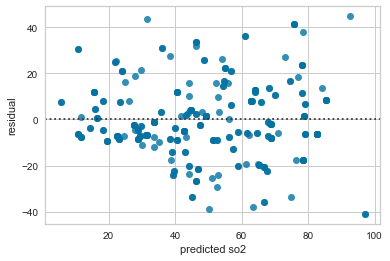

In [21]:
res = Y-pred_y

g = sns.residplot(pred_y,res)

g.set(xlabel='predicted so2', ylabel='residual')

plt.show()

# interesting graphs

### congestion_model vs car.count

slope, intercept, r_value, p_value, std_err =  LinregressResult(slope=0.011904107130927983, intercept=28.461002837633416, rvalue=0.5212778842690416, pvalue=8.168779833606287e-22, stderr=0.0011424233042684991)


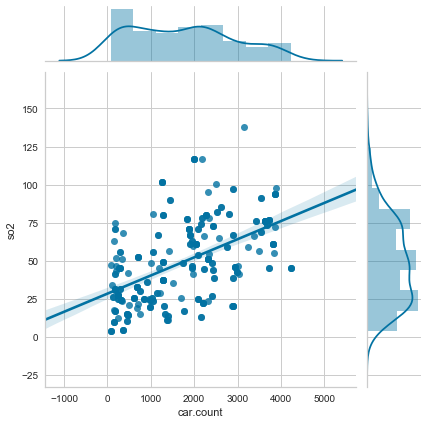

In [47]:
x = TRAIN['car.count']
y = TRAIN['so2']

sns.jointplot(x,y,kind='reg')

print('slope, intercept, r_value, p_value, std_err = ',stats.linregress(x,y))

slope, intercept, r_value, p_value, std_err =  LinregressResult(slope=4.840190665281032, intercept=24.385338200802764, rvalue=0.5989712647638366, pvalue=6.463298852927362e-30, stderr=0.3793307617780464)


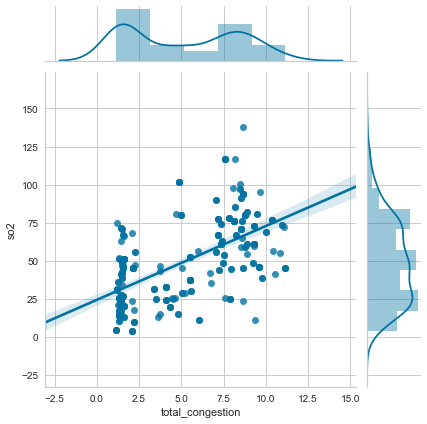

In [50]:
x = TRAIN['total_congestion']
y = TRAIN['so2']

sns.jointplot(x,y,kind='reg')

print('slope, intercept, r_value, p_value, std_err = ',stats.linregress(x,y))